* 학번,이름 필수!
* 채점자가 알아보기 명확하도록 결과물 출력

<b>
1. S에서 출발해서 G에 도착하면 끝 <br>
2. 회색 영역은 지나갈 수 없는 벽이 놓여 있는 곳 <br>
3. 보상은 스텝마다 -1 (즉, 최단 거리로 G에 도달하는 것이 목적)
</b>

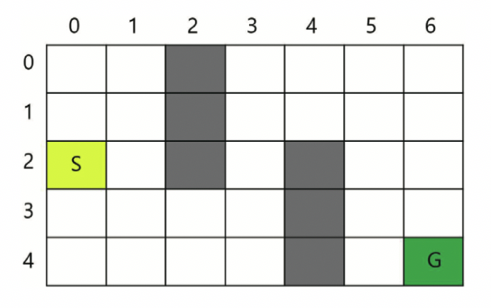

<b> [문제 1] 위 그리드월드를 몬테카를로 컨트롤로 학습하시오.

[[3. 3. 0. 2. 2. 3. 3.]
 [3. 3. 0. 2. 2. 3. 3.]
 [2. 3. 0. 1. 0. 3. 3.]
 [2. 2. 2. 1. 0. 3. 3.]
 [1. 2. 2. 1. 0. 2. 0.]]


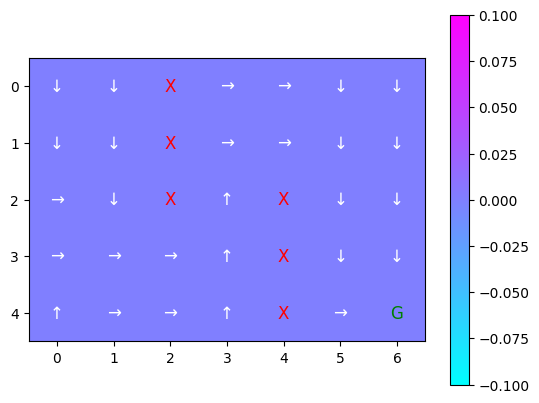

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt


############################### 환경 : 에이전트의 액션을 받아 상태변이를 일으키고, 보상을 줌
class GridWorld:
    def __init__(self):
        self.grid_size = (5, 7)
        self.start = (2, 0)
        self.goal = (4, 6)
        self.walls = [(0, 2), (1, 2), (2, 2), (2, 4), (3, 4), (4, 4)]
        self.x, self.y = self.start

    def step(self, a):
        # 0번 액션: 왼쪽, 1번 액션: 위, 2번 액션: 오른쪽, 3번 액션: 아래쪽
        if a == 0:
            self.move_left()
        elif a == 1:
            self.move_up()
        elif a == 2:
            self.move_right()
        elif a == 3:
            self.move_down()

        reward = -1 # 보상은 항상 -1로 고정
        done = self.is_done()
        return (self.x, self.y), reward, done

    def move_left(self):
        if self.y == 0:
            pass
        elif self.y == 3 and self.x in [0, 1, 2]:
            pass
        elif self.y == 5 and self.x in [2, 3, 4]:
            pass
        else:
            self.y -= 1

    def move_right(self):
        if self.y == 1 and self.x in [0, 1, 2]:
            pass
        elif self.y == 3 and self.x in [2, 3, 4]:
            pass
        elif self.y == 6:
            pass
        else:
            self.y += 1

    def move_up(self):
        if self.x == 0:
            pass
        elif self.x == 3 and self.y == 2:
            pass
        else:
            self.x -= 1

    def move_down(self):
        if self.x == 4:
            pass
        elif self.x == 1 and self.y == 4:
            pass
        else:
            self.x += 1

    def is_done(self):
        if (self.x, self.y) == self.goal: # 목표 지점인 (4,6)에 도달하면 끝난다
            return True
        else:
            return False

    def reset(self):
        self.x = 0
        self.y = 0
        return (self.x, self.y)

    def plot_grid(self, optimal_policy):
        plt.imshow(np.zeros_like(optimal_policy), cmap='cool', origin='upper')  # origin을 'upper'로 변경
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                if (i, j) in self.walls:
                    arrow = 'X'
                    color = 'red'
                elif (i, j) == self.goal:
                    arrow = 'G'
                    color = 'green'
                else:
                    action = optimal_policy[i, j]
                    if action == 0:
                        arrow = '←'
                    elif action == 1:
                        arrow = '↑'
                    elif action == 2:
                        arrow = '→'
                    else:
                        arrow = '↓'
                    color = 'white'
                plt.text(j, i, arrow, ha='center', va='center', color=color, fontsize=12)

        plt.colorbar()
        plt.show()

############################### 에이전트 : 정책을 따라 움직임        
class QAgent:
    def __init__(self):
        # np.zeros((행, 열, 깊이)) - 깊이 0,1,2,3은 액션 0,1,2,3에 해당
        self.q_table = np.zeros((5, 7, 4)) # q벨류를 저장하는 변수. 모두 0으로 초기화
        self.eps = 0.9
        self.alpha = 0.01

    def select_action(self, s):
        # eps-greedy로 액션을 선택
        x, y = s
        coin = random.random() # 0~1 사이의 난수 생성
        if coin < self.eps:
            action = random.randint(0, 3) # 랜덤 액션(0~3) 선택
        else:
            action_val = self.q_table[x, y, :]
            action = np.argmax(action_val) # 액션가치가 최댓인 액션의 인덱스 반환
        return action

    def update_table(self, history):
        # 한 에피소드에 해당하는 history를 입력으로 받아 q 테이블의 값을 업데이트
        cum_reward = 0
        for transition in history[::-1]:
            s, a, r, s_prime = transition
            x, y = s
            # 몬테 카를로 방식을 이용하여 업데이트.
            self.q_table[x, y, a] = self.q_table[x, y, a] + self.alpha * (cum_reward - self.q_table[x, y, a])
            cum_reward = cum_reward + r

    def anneal_eps(self):
        # epsilon 값을 조금씩 줄이는 함수
        self.eps -= 0.03
        self.eps = max(self.eps, 0.1) # 0.1 이하로는 줄어들지 않도록 함
        
    def show_table(self):
        # 학습이 각 위치에서 어느 액션의 q 값이 가장 높았는지 보여주는 함수
        q_lst = self.q_table.tolist()
        data = np.zeros((5,7))
        for row_idx in range(len(q_lst)):
            row = q_lst[row_idx]
            for col_idx in range(len(row)):
                col = row[col_idx]
                action = np.argmax(col)
                data[row_idx, col_idx] = action
        print(data)

def main():
    env = GridWorld()
    agent = QAgent()

    for n_epi in range(50000):
        done = False
        history = []

        s = env.reset() # (0,0)으로 reset
        while not done: # 한 에피소드가 끝날 때 까지
            a = agent.select_action(s)
            s_prime, r, done = env.step(a)
            history.append((s, a, r, s_prime))
            s = s_prime
        agent.update_table(history) # 에피소드가 끝난 후 - 히스토리 이용하여 에이전트 업데이트
        agent.anneal_eps()  # epsilon 값 조금씩 줄이기
    
    optimal_policy = np.argmax(agent.q_table, axis=2)
    agent.show_table() # 학습이 끝난 결과를 출력
    env.plot_grid(optimal_policy) # 학습이 끝난 결과를 출력

if __name__ == '__main__':
    main()


<b> [문제 2] 위 그리드월드를 TD 컨트롤 (SARSA)로 학습하시오. </b>

[[3. 3. 0. 3. 2. 2. 3.]
 [3. 3. 0. 2. 2. 2. 3.]
 [2. 3. 0. 1. 0. 2. 3.]
 [2. 2. 2. 1. 0. 3. 3.]
 [2. 2. 1. 1. 0. 2. 0.]]


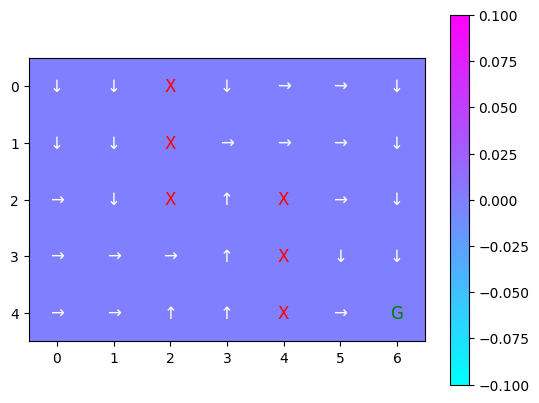

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt

############################### 환경: 에이전트의 액션을 받아 상태변이를 일으키고 보상을 줌
class GridWorld:
    def __init__(self):
        self.grid_size = (5, 7)
        self.start = (2, 0)
        self.goal = (4, 6)
        self.walls = [(0, 2), (1, 2), (2, 2), (2, 4), (3, 4), (4, 4)]
        self.x, self.y = self.start

    def step(self, a):
        # 0번 액션: 왼쪽, 1번 액션: 위, 2번 액션: 오른쪽, 3번 액션: 아래쪽
        if a == 0:
            self.move_left()
        elif a == 1:
            self.move_up()
        elif a == 2:
            self.move_right()
        elif a == 3:
            self.move_down()

        reward = -1 # 보상은 항상 -1로 고정
        done = self.is_done()
        return (self.x, self.y), reward, done

    def move_left(self):
        if self.y == 0:
            pass
        elif self.y == 3 and self.x in [0, 1, 2]:
            pass
        elif self.y == 5 and self.x in [2, 3, 4]:
            pass
        else:
            self.y -= 1

    def move_right(self):
        if self.y == 1 and self.x in [0, 1, 2]:
            pass
        elif self.y == 3 and self.x in [2, 3, 4]:
            pass
        elif self.y == 6:
            pass
        else:
            self.y += 1

    def move_up(self):
        if self.x == 0:
            pass
        elif self.x == 3 and self.y == 2:
            pass
        else:
            self.x -= 1

    def move_down(self):
        if self.x == 4:
            pass
        elif self.x == 1 and self.y == 4:
            pass
        else:
            self.x += 1

    def is_done(self):
        if (self.x, self.y) == self.goal: # 목표 지점인 (4,6)에 도달하면 끝난다
            return True
        else:
            return False

    def reset(self):
        self.x = 0
        self.y = 0
        return (self.x, self.y)

    def plot_grid(self, optimal_policy):
        plt.imshow(np.zeros_like(optimal_policy), cmap='cool', origin='upper')  # origin을 'upper'로 변경
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                if (i, j) in self.walls:
                    arrow = 'X'
                    color = 'red'
                elif (i, j) == self.goal:
                    arrow = 'G'
                    color = 'green'
                else:
                    action = optimal_policy[i, j]
                    if action == 0:
                        arrow = '←'
                    elif action == 1:
                        arrow = '↑'
                    elif action == 2:
                        arrow = '→'
                    else:
                        arrow = '↓'
                    color = 'white'
                plt.text(j, i, arrow, ha='center', va='center', color=color, fontsize=12)

        plt.colorbar()
        plt.show()

############################### 에이전트: 정책을 따라 움직임
class QAgent:
    def __init__(self):
        self.q_table = np.zeros((5, 7, 4)) # 마찬가지로 Q 테이블을 0으로 초기화
        self.eps = 0.9

    def select_action(self, s):
        # eps-greedy로 액션을 선택해준다
        x, y = s
        coin = random.random()
        if coin < self.eps:
            action = random.randint(0, 3)
        else:
            action_val = self.q_table[x, y, :]
            action = np.argmax(action_val)
        return action

    def update_table(self, transition):
        s, a, r, s_prime = transition
        x, y = s
        next_x, next_y = s_prime
        a_prime = self.select_action(s_prime) # S'에서 선택할 액션 (실제로 취한 액션이 아님)
        # SARSA 업데이트 식을 이용
        self.q_table[x, y, a] = self.q_table[x, y, a] + 0.1 * (r + self.q_table[next_x, next_y, a_prime] - self.q_table[x, y, a])

    def anneal_eps(self):
        self.eps -= 0.03
        self.eps = max(self.eps, 0.1)

    def show_table(self):
        q_lst = self.q_table.tolist()
        data = np.zeros((5, 7))
        for row_idx in range(len(q_lst)):
            row = q_lst[row_idx]
            for col_idx in range(len(row)):
                col = row[col_idx]
                action = np.argmax(col)
                data[row_idx, col_idx] = action
        print(data)
        return data

def main():
    env = GridWorld()
    agent = QAgent()

    for n_epi in range(50000):
        done = False
        s = env.reset()

        while not done:
            a = agent.select_action(s)
            s_prime, r, done = env.step(a)
            agent.update_table((s, a, r, s_prime)) # transition마다 업데이트
            s = s_prime
        agent.anneal_eps() # epsilon 값 조금씩 줄이기

    optimal_policy = agent.show_table()
    env.plot_grid(optimal_policy) # 학습이 끝난 결과를 출력

if __name__ == '__main__':
    main()
